In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df=pd.read_csv('dataset/boulder_results.csv')

In [3]:
df.head()

,Competition Title,Competition Date,FIRST,LAST,Nation,StartNr,Rank,Qualification,Qualification 1,Qualification 2,Semifinal,Final,Category
0,European Youth Championships (B) - Brixen (ITA...,20 - 22 September 2019,Naile,MEIGNAN,FRA,15.0,1,6T7z99,NaN,NaN,3T4z55,3T4z89,boulder
1,European Youth Championships (B) - Brixen (ITA...,20 - 22 September 2019,Miriam,FOGU,ITA,27.0,2,4T8z814,NaN,NaN,3T4z55,2T4z27,boulder
2,European Youth Championships (B) - Brixen (ITA...,20 - 22 September 2019,Vanda,MICHALKOVA,SVK,48.0,3,6T7z89,NaN,NaN,3T3z43,2T3z23,boulder
3,European Youth Championships (B) - Brixen (ITA...,20 - 22 September 2019,Lola,SAUTIER,FRA,17.0,4,4T6z69,NaN,NaN,2T3z89,1T3z38,boulder
4,European Youth Championships (B) - Brixen (ITA...,20 - 22 September 2019,Polina,KULAGINA,RUS,39.0,5,4T6z611,NaN,NaN,3T4z76,1T3z47,boulder


# Project Goal: Make a model to predict how good a player should perform to pass the Qualification

### How to evaluate the score
Bouldering is scored using a combination of tops and zones to determine rank. Athletes each get four minutes to reach the top of four boulders (three in the final), with the number of attempts influencing their final score. The aim is to top the boulder in as few attempts as possible.

Results are in the format Tz__. T corresponds to top, which means the climber reached the top hold and finished the problem. z corresponds to zone, which means the climber reached the zone hold and partially finished the problem. The numbers before each correspond to how many tops or zones were reached, and numbers after signify how many attempts were taken.

Example:
2T4z58 means that the climber had 2 tops, 4 zones, and took 5 total attempts to get the tops, and 8 total attempts to reach the zones.

Qualification: Sometimes there are multiple groups for qualifications, and when that is the case the results will be split to indicate which qualification group the climber was in.

### Plan ahead
#### Data Acquisition
Use a dataset in Kaggle. (Source: IFSC Sport Climbing Competition Results)
#### Feature Engineering
Narrow down our interst to adult competition only.

Merge Qualification, Qual1, and Qual2 columns together for the reason mentioned above.

Re-frame the string score data to numeric variables and check the correlation to the passing Qual.

#### Train / Test models
Perform various classification methods: Logistic Regression, Tree-based mehtod, and Support Vector Classifier.

#### Evalutation of the model

Consider accuracy and f1 score: Generally good score to evaluate the model.

Recall/Precision: Missing pass/fail Qual is not critical

## Data Cleaning

In [4]:
# Merge Qualification scores in one column
# print the number of null values and see if it decreases to 0
print(df['Qualification'].isnull().sum())
df['Qualification'].fillna(df['Qualification 1'], inplace=True)
print(df['Qualification'].isnull().sum())
df['Qualification'].fillna(df['Qualification 2'], inplace=True)
print(df['Qualification'].isnull().sum())

4309
2155
0


In [5]:
# Remove Qual 1 Qual 2 Columns
if df['Qualification'].isnull().sum()==0:
    df = df.drop(['Qualification 1','Qualification 2'], axis=1)

In [6]:
# Get rid of the Youth competition
df = df[~df['Competition Title'].str.contains('Youth')]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3197 entries, 282 to 6468
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Competition Title  3197 non-null   object 
 1   Competition Date   3197 non-null   object 
 2   FIRST              3197 non-null   object 
 3   LAST               3197 non-null   object 
 4   Nation             3197 non-null   object 
 5   StartNr            3197 non-null   float64
 6   Rank               3197 non-null   int64  
 7   Qualification      3197 non-null   object 
 8   Semifinal          800 non-null    object 
 9   Final              260 non-null    object 
 10  Category           3197 non-null   object 
dtypes: float64(1), int64(1), object(9)
memory usage: 299.7+ KB


In [7]:
df['Category'].unique()

array(['ldering'], dtype=object)

In [8]:
df.drop('Category', axis=1, inplace=True)

In [9]:
df.head()

,Competition Title,Competition Date,FIRST,LAST,Nation,StartNr,Rank,Qualification,Semifinal,Final
282,European Championship (B) - Zakopane (POL) 2019,5 - 7 September 2019,Urska,REPUSIC,SLO,63.0,1,3T4z68,3T4z67,3T4z45
283,European Championship (B) - Zakopane (POL) 2019,5 - 7 September 2019,Vita,LUKAN,SLO,61.0,2,5T5z118,3T4z57,3T4z68
284,European Championship (B) - Zakopane (POL) 2019,5 - 7 September 2019,Irina,KUZMENKO,RUS,68.0,3,5T5z1513,3T4z510,3T4z817
285,European Championship (B) - Zakopane (POL) 2019,5 - 7 September 2019,Alma,BESTVATER,GER,67.0,4,4T4z84,3T4z46,3T3z33
286,European Championship (B) - Zakopane (POL) 2019,5 - 7 September 2019,Yael,TAUB,ISR,90.0,5,2T5z410,3T4z56,2T3z46


## Feature Engineering part 1: Convert string scores to numerical values
1. Quantify the score from string to integers (# of tops, # of zones, # of top attempts, # of zone attempts)

2. Make another columns to check if the player pass the Qual. If the player has semifinal score, consider the one passed the qualification.

3. Check the correlation between each score (top, zone, top attempt, and zone attpemt) to passing Qual. Check the distribution of each number as well.

In [10]:
def score(row, rnd): # rnd: string 'Qualification', 'Semifinal', Final
    temp = row[rnd].split('T')
    top = int(temp[0])
    temp = temp[1].split('z')
    zone = int(temp[0])
    
    # t_attempt >= top
    # z_attempt >= zone
    t_attempt = temp[1][0]  # Initial condition: first number after "z"
    i=1
    while int(t_attempt)<top:
        t_attempt=t_attempt+temp[1][i]
        i+=1
    
    z_attempt=temp[1][len(t_attempt):]
    if len(z_attempt)>2: # Attempts more than 100 is physically impossible. (you only have 4 mins)
        t_attempt=t_attempt+temp[1][len(t_attempt)]
        
    z_attempt = temp[1][len(t_attempt):]
    
    
    t_attempt=int(t_attempt)
    z_attempt=int(z_attempt)
    
    return [top, zone, t_attempt, z_attempt]

In [11]:
columns_to_add = ['Qual top', 'Qual zone', 'Qual top attempts', 'Qual zone attempts']
for idx, col in enumerate(columns_to_add):
    df[col] = df.apply(lambda row,rnd='Qualification': score(row,rnd)[idx], axis=1)

# Having Semifinal score -> Passed Qualification!

df['Pass Qual']=df['Semifinal'].notnull()
df['Qual result']=df['Pass Qual'].map({True:'Pass', False: 'Fail'})
df.head()

,Competition Title,Competition Date,FIRST,LAST,Nation,StartNr,Rank,Qualification,Semifinal,Final,Qual top,Qual zone,Qual top attempts,Qual zone attempts,Pass Qual,Qual result
282,European Championship (B) - Zakopane (POL) 2019,5 - 7 September 2019,Urska,REPUSIC,SLO,63.0,1,3T4z68,3T4z67,3T4z45,3,4,6,8,True,Pass
283,European Championship (B) - Zakopane (POL) 2019,5 - 7 September 2019,Vita,LUKAN,SLO,61.0,2,5T5z118,3T4z57,3T4z68,5,5,11,8,True,Pass
284,European Championship (B) - Zakopane (POL) 2019,5 - 7 September 2019,Irina,KUZMENKO,RUS,68.0,3,5T5z1513,3T4z510,3T4z817,5,5,15,13,True,Pass
285,European Championship (B) - Zakopane (POL) 2019,5 - 7 September 2019,Alma,BESTVATER,GER,67.0,4,4T4z84,3T4z46,3T3z33,4,4,8,4,True,Pass
286,European Championship (B) - Zakopane (POL) 2019,5 - 7 September 2019,Yael,TAUB,ISR,90.0,5,2T5z410,3T4z56,2T3z46,2,5,4,10,True,Pass


#### Check if the scores are correctly generated
Attempts should be >= top or zone!

In [12]:
len(df[df['Qual zone attempts']<df['Qual zone']])

0

In [13]:
len(df[df['Qual top attempts']<df['Qual top']])

0

Both are zero. The scores are nicely converted.

## Data Engineering part 2: Check the score vs passing qual

In [14]:
df_qual = df[['Qual top','Qual zone','Qual top attempts','Qual zone attempts','Pass Qual','Qual result']]

In [15]:
df_qual.corr()['Pass Qual']

Qual top              0.657668
Qual zone             0.523052
Qual top attempts     0.474940
Qual zone attempts    0.155779
Pass Qual             1.000000
Name: Pass Qual, dtype: float64

As expected Qual top shows the strongest correation.

In [16]:
df_qual = df_qual.drop('Pass Qual',axis=1)

<AxesSubplot:xlabel='Qual top', ylabel='count'>

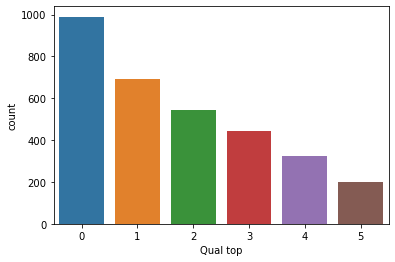

In [17]:
sns.countplot(x=df_qual['Qual top'])

### Visualize how passing qual is correlated wity each score value 

Count plot and box plot of each columns with hue='Pass Qual'

<AxesSubplot:xlabel='Qual top', ylabel='count'>

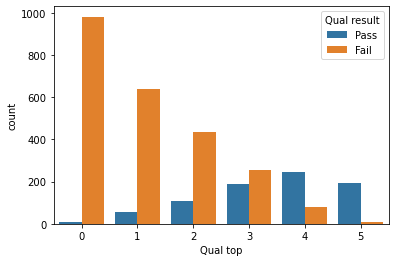

In [18]:
sns.countplot(x=df_qual['Qual top'], hue=df_qual['Qual result'])

<AxesSubplot:xlabel='Qual result', ylabel='Qual top'>

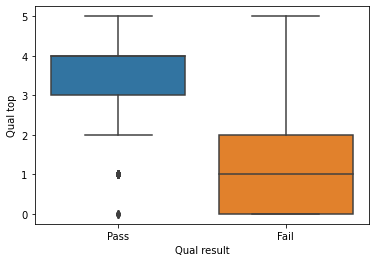

In [19]:
sns.boxplot(x=df_qual['Qual result'], y=df_qual['Qual top'])

### Interpretation Top vs Passing Qual: Low top score is strong indicator of Qual Failure 
There are some exceptions (some players passed qualification with 0 or 1 top), but higher top score leads a player to the next round.
This result is making sense.

## Qual zone vs Passing Qual

<AxesSubplot:xlabel='Qual zone', ylabel='count'>

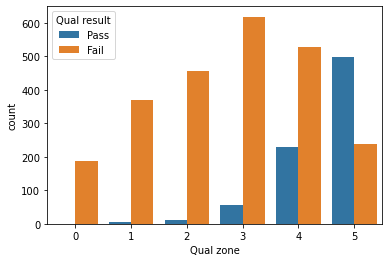

In [20]:
sns.countplot(x=df_qual['Qual zone'], hue=df_qual['Qual result'])

<AxesSubplot:xlabel='Qual result', ylabel='Qual zone'>

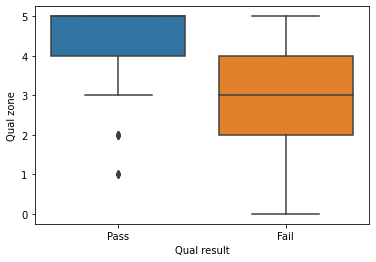

In [21]:
sns.boxplot(x=df_qual['Qual result'],y=df_qual['Qual zone'])

Text(0.5, 1.0, '5 Zone')

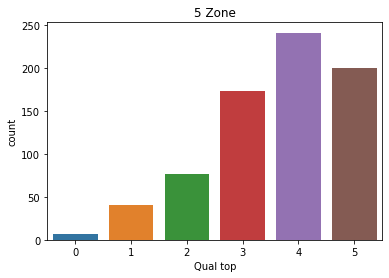

In [22]:
# Distribution of top who scored 5zone!
sns.countplot(x=df_qual[df_qual['Qual zone']==5]['Qual top'])
plt.title('5 Zone')

Text(0.5, 1.0, '4 Zone')

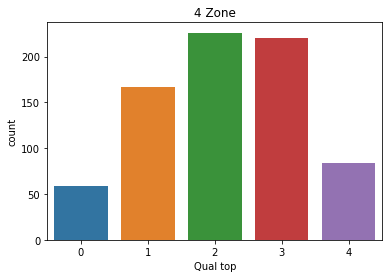

In [23]:
# Distribution of top who scored 4zone!
sns.countplot(x=df_qual[df_qual['Qual zone']==4]['Qual top'])
plt.title('4 Zone')

In [24]:
df_qual.corr()['Qual top']

Qual top              1.000000
Qual zone             0.765812
Qual top attempts     0.811902
Qual zone attempts    0.239009
Name: Qual top, dtype: float64

### Interpretation Zone vs Passing Qual: Zone can be even stronger feature to predict who passes the Qualification than the top!!!
This does not make sense at the first glance becuase the top is the strongest score. However, if you top the problem, then zone is secured (1T0z is impossible). Therefore zone can be correlated with top. (and, yes they are! corr = 0.7658)

## Top attempts vs passing Qual

<AxesSubplot:xlabel='Qual top attempts', ylabel='count'>

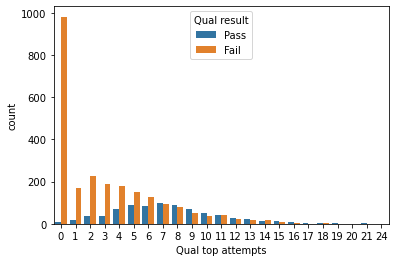

In [25]:
sns.countplot(x=df_qual['Qual top attempts'], hue=df_qual['Qual result'])

Those who passed Qual mostly attempt 5~8 to top the problems. This looks reasonable because of reasons.

1. Lower limit of top attempt is top score. If you flashed (top at the first attempt) 5 problems in a row (best case scenario), your attempt will be 5.

2. Players who passed the Qual mostly scored 4T or 5T. Top attempts a little bit higher than this number means they mostly flashed their problem.

There are a lot of players who could not attempt to top a single problem. These players secured no top, so let's look at their zone scores.

Text(0.5, 1.0, '0 top attempt')

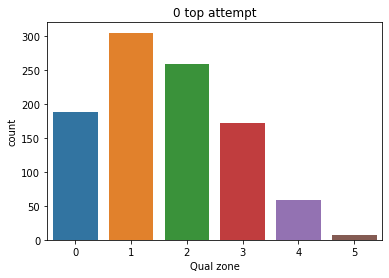

In [26]:
# Distribution of top who scored 0 top attempt!
sns.countplot(x=df_qual[df_qual['Qual top attempts']==0]['Qual zone'])
plt.title('0 top attempt')

### Interpretation of top attempt vs Passing Qual: Highly conditional!
Those who passed the qual mostly attempts 4~8 times to top the problem, and it makes sense as previously explained.

However, when it comes to predict those who failed to qualify, lower top attempts become a good indicator.


## Zone attempt vs Passign Qualification
I expect this zone attempt has similar trend as top attempts with weaker correlation to the passing qual.

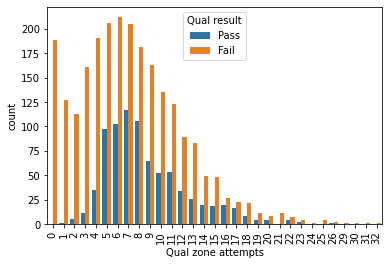

In [27]:
sns.countplot(x=df_qual['Qual zone attempts'], hue=df_qual['Qual result'])
plt.tick_params(axis='x', rotation=90)

And, Yes it is!

# Model Selection

Throughout the feature engineering, I figured out the top and zone socres are somewhat linearly correlated to passing qual. My intuition says linear logistic regression would work fine. Let's make logistic, tree-based, and SVM based classification models and evalueate them.

## Logistic Regression

In [28]:
from sklearn.model_selection import train_test_split
X_qual = df_qual.drop('Qual result',axis=1)
y_qual = df_qual['Qual result']

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X_qual, y_qual, test_size=0.1)

#### Import Libraries

In [30]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [31]:
scaler=StandardScaler()
log_model=LogisticRegression(penalty='elasticnet', solver='saga', max_iter=3000)
# saga is the only solver available for elasticnet
# Default max_iter: 100, seems a bit small

In [32]:
# Construct Pipeline: Standard scale and logistic model with elastic net regularization
operations_logistic = [('scaler',scaler),('log_model',log_model)]
pipe_logistic = Pipeline(operations_logistic)

#### Let's start with logistic regression with elasticnet regularization 

In [33]:
param_grid = {'log_model__C':np.logspace(-2,2,20),'log_model__l1_ratio':np.linspace(0,1,20)}
cv_logistic = GridSearchCV(pipe_logistic, param_grid=param_grid, cv=10, scoring='accuracy')

In [34]:
cv_logistic.fit(X_train,y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('log_model',
                                        LogisticRegression(max_iter=3000,
                                                           penalty='elasticnet',
                                                           solver='saga'))]),
             param_grid={'log_model__C': array([1.00000000e-02, 1.62377674e-02, 2.63665090e-02, 4.28133240e-02,
       6.95192796e-02, 1.12883789e-01, 1.83298071e-01, 2.97635144e-01,
       4.83293024e-01, 7.84759970e-01, 1.274274...
       3.35981829e+00, 5.45559478e+00, 8.85866790e+00, 1.43844989e+01,
       2.33572147e+01, 3.79269019e+01, 6.15848211e+01, 1.00000000e+02]),
                         'log_model__l1_ratio': array([0.        , 0.05263158, 0.10526316, 0.15789474, 0.21052632,
       0.26315789, 0.31578947, 0.36842105, 0.42105263, 0.47368421,
       0.52631579, 0.57894737, 0.63157895, 0.68421053, 0.73684211

In [35]:
cv_logistic.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()),
                ('log_model',
                 LogisticRegression(C=23.357214690901213,
                                    l1_ratio=0.6842105263157894, max_iter=3000,
                                    penalty='elasticnet', solver='saga'))])

l1_ratio=0: Just L2 regularized logistic regression model

### Evaluate the logistic regression model

In [36]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

In [37]:
y_pred_logistic = cv_logistic.predict(X_test)

              precision    recall  f1-score   support

        Fail       0.90      0.94      0.92       250
        Pass       0.76      0.64      0.70        70

    accuracy                           0.88       320
   macro avg       0.83      0.79      0.81       320
weighted avg       0.87      0.88      0.87       320



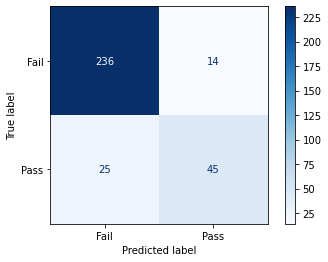

In [38]:
print(classification_report(y_test,y_pred_logistic))
ConfusionMatrixDisplay.from_estimator(cv_logistic,X_test,y_test,cmap='Blues')

### Good at predicting "Not Passing Qual" but not good at predicting "Passing Qual"
#### What does this mean regarding the model performance?

The dataset is a bit imbalanced: There are a lot more Failed cases (229) than the Passing cases (91). The model is trained with accuracy and prediction can be biased (or weighted) toward "a player will not pass the Qual".

## Decision tree based model: Random Forest
Random Forest model because

1. No need to worry about overfitting

2. Generally better performance than single tree method

In [39]:
from sklearn.ensemble import RandomForestClassifier

In [40]:
rfc = RandomForestClassifier(max_features=2) # We have 4 features and library suggested using log2 (4) or sqrt(4); basically 2.

We don't need to scale the features because Tree based method only use one feature in a node.

In [41]:
rfc.fit(X_train,y_train)

RandomForestClassifier(max_features=2)

In [42]:
y_pred_forest = rfc.predict(X_test)

In [43]:
print(X_train.columns)
print(rfc.feature_importances_)

Index(['Qual top', 'Qual zone', 'Qual top attempts', 'Qual zone attempts'], dtype='object')
[0.38738157 0.20247568 0.20818331 0.20195944]


The forest model evaluate the importance: Top > Top Attempts > Zone Attempts > Zone: This is quite counter-intuitive!

### Evaluate the Forest Model
The forest model is worse in predicting both Passing Qual and Failing Qual than the logistic regression model. Let's try SVM-Classifier.

              precision    recall  f1-score   support

        Fail       0.89      0.90      0.90       250
        Pass       0.64      0.61      0.63        70

    accuracy                           0.84       320
   macro avg       0.77      0.76      0.76       320
weighted avg       0.84      0.84      0.84       320



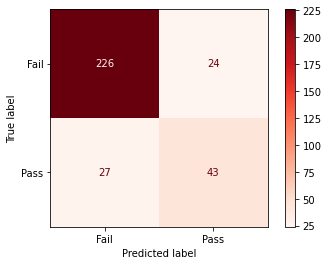

In [44]:
print(classification_report(y_test,y_pred_forest))
ConfusionMatrixDisplay.from_estimator(rfc,X_test,y_test,cmap='Reds')

## Support Vector Machine based model: SVC

In [45]:
from sklearn.svm import SVC

In [46]:
svc=SVC() # Gridsearch 'C', 'gamma'
operation_svc = [('scaler',scaler),('svc',svc)]
pipe_svc = Pipeline(operation_svc)


param_grid={'svc__C':np.logspace(-2,2,20),'svc__gamma':['scale','auto']}
grid_svc = GridSearchCV(pipe_svc, param_grid, scoring='accuracy')

In [47]:
grid_svc.fit(X_train,y_train)

GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('svc', SVC())]),
             param_grid={'svc__C': array([1.00000000e-02, 1.62377674e-02, 2.63665090e-02, 4.28133240e-02,
       6.95192796e-02, 1.12883789e-01, 1.83298071e-01, 2.97635144e-01,
       4.83293024e-01, 7.84759970e-01, 1.27427499e+00, 2.06913808e+00,
       3.35981829e+00, 5.45559478e+00, 8.85866790e+00, 1.43844989e+01,
       2.33572147e+01, 3.79269019e+01, 6.15848211e+01, 1.00000000e+02]),
                         'svc__gamma': ['scale', 'auto']},
             scoring='accuracy')

In [48]:
grid_svc.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()),
                ('svc', SVC(C=61.584821106602604))])

In [49]:
grid_svc.best_params_

{'svc__C': 61.584821106602604, 'svc__gamma': 'scale'}

              precision    recall  f1-score   support

        Fail       0.88      0.95      0.92       250
        Pass       0.76      0.56      0.64        70

    accuracy                           0.87       320
   macro avg       0.82      0.75      0.78       320
weighted avg       0.86      0.87      0.86       320



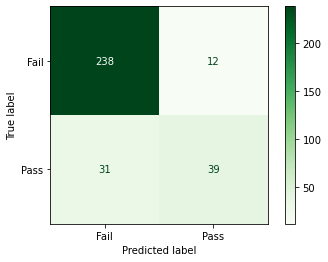

In [50]:
y_pred_svc = grid_svc.predict(X_test)
print(classification_report(y_test,y_pred_svc))
ConfusionMatrixDisplay.from_estimator(grid_svc,X_test,y_test,cmap='Greens')

# Model Evaluation and Selection

Logistic Regression Model
              precision    recall  f1-score   support

        Fail       0.90      0.94      0.92       250
        Pass       0.76      0.64      0.70        70

    accuracy                           0.88       320
   macro avg       0.83      0.79      0.81       320
weighted avg       0.87      0.88      0.87       320


Random Forest Model
              precision    recall  f1-score   support

        Fail       0.89      0.90      0.90       250
        Pass       0.64      0.61      0.63        70

    accuracy                           0.84       320
   macro avg       0.77      0.76      0.76       320
weighted avg       0.84      0.84      0.84       320


Support Vector Classifier Model
              precision    recall  f1-score   support

        Fail       0.88      0.95      0.92       250
        Pass       0.76      0.56      0.64        70

    accuracy                           0.87       320
   macro avg       0.82      0.75      0.78     

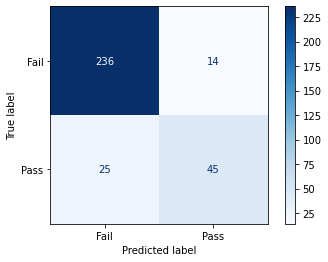

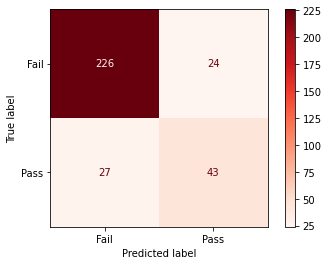

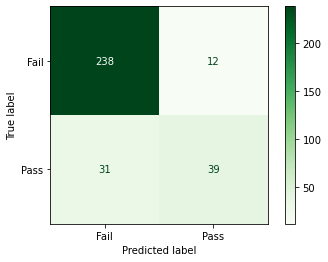

In [51]:
print("Logistic Regression Model")
print(classification_report(y_test,y_pred_logistic))
ConfusionMatrixDisplay.from_estimator(cv_logistic,X_test,y_test,cmap='Blues')
print('\nRandom Forest Model')
print(classification_report(y_test,y_pred_forest))
ConfusionMatrixDisplay.from_estimator(rfc,X_test,y_test,cmap='Reds')
print('\nSupport Vector Classifier Model')
print(classification_report(y_test,y_pred_svc))
ConfusionMatrixDisplay.from_estimator(grid_svc,X_test,y_test,cmap='Greens')

# Conclusion
Regardless of model of choice, predicting failing qual is quite accurate in terms of both precision and recall. It means the negative prediction is correct in most cases and the models catch failure cases quite accurately.

Given that the accuracy is a good parameter to evaluate the overall performance, I found no significant difference between performance of Logistic model and Support Vector classification model. I would choose logistic model to predict one's qualification result because it is slightly better in performance.